# Lab 1

Due:

October 13th

Grading:

Report 80 Percent, Code 20 Percent

## Part 1: Noisy Circuits [40 Points]

In [1]:
# Import Necessary Libraries
from qiskit import QuantumCircuit, Aer, execute, transpile
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_error_map
from qiskit.providers.fake_provider import FakeLimaV2, FakeQuitoV2, FakeRomeV2, FakeMontrealV2, FakeKolkataV2, FakeAthensV2, FakeAlmadenV2, FakeCambridgeV2
from qiskit.visualization import plot_circuit_layout
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
import math
import random
import inspect
import warnings

warnings.filterwarnings('ignore')

In [2]:
def compute_hdist(dist1: dict[str, float], dist2: dict[str, float]) -> float:
    outcomes = set(dist1.keys()).union(set(dist2.keys()))
    shots1 = sum(dist1.values())
    shots2 = sum(dist2.values())
    sqrtp1 = {outcome: math.sqrt(dist1.get(outcome, 0) / shots1)
              for outcome in outcomes}
    sqrtp2 = {outcome: math.sqrt(dist2.get(outcome, 0) / shots2)
              for outcome in outcomes}

    return math.sqrt(sum((sqrtp1[outcome] - sqrtp2[outcome])**2 for outcome in outcomes) / 2)

def execute_simulator(circuit: QuantumCircuit, simulator):
    job = execute(circuit, simulator, shots=1024)
    result = job.result()
    counts = result.get_counts()
    plot_histogram(counts)
    return counts


def get_name(value):
    if inspect.isclass(value):
        return value.__name__
    if inspect.isfunction(value):
        return value.__name__
    return value


def make_plots(parameters: list[any], runner, parameter_name, x_axis, xlabel, ylabel) -> None:
    for parameter in parameters:
        y_axis = runner(parameter)
        x_axis_new = {x: val for x, val in x_axis.items() if val in y_axis.keys()}

        plt.plot(x_axis_new.keys(), y_axis.values())
        texts = [plt.text(x, y_axis[value], get_name(value), fontdict=dict(
            color='red')) for x, value in x_axis_new.items()]
        adjust_text(texts, only_move={'points': '', 'text': 'x'})

        plt.title(
            f"Circuit: {runner.__name__}\n{parameter_name}: {get_name(parameter)}")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.savefig(f"Lab1/{runner.__name__}_{get_name(parameter)}.png")
        plt.clf()

In [3]:
backends = {8: FakeLimaV2, 16: FakeQuitoV2,
            32: FakeRomeV2, 64: FakeMontrealV2, 128: FakeKolkataV2}


def run_circuit(parameter: int, circuit_generator):
    circuit = circuit_generator(parameter)
    ideal_simulator = Aer.get_backend('statevector_simulator')
    ideal_result = execute_simulator(circuit, ideal_simulator)

    hdists = dict()
    for backend in backends.values():
        noisy_result = execute_simulator(
            circuit, AerSimulator.from_backend(backend()))
        hdists[backend] = compute_hdist(ideal_result, noisy_result)

    return hdists

#### Question 1 [10 Points]:
For this first question you have to create code to produce the GHZ State and measure how the produced distribution matches or differs from the expected outcome. Your measurement will be in the form of a success metric, such as the probability of success of your circuit. Your task is to implement the functions given below and then  select one of the metrics given in class. Note that for evaluation you will need to simulate with both a noisy simulator and an ideal one.

In [4]:
def make_ghz(num_qubits: int, display=False) -> QuantumCircuit:
    ghz_circuit = QuantumCircuit(num_qubits)
    ghz_circuit.h(0)
    for i in range(num_qubits-1):
        ghz_circuit.cx(i, i+1)
    ghz_circuit.measure_all()
    if display:
        print(ghz_circuit)
    return ghz_circuit

#### Question 2 [10 Points]:
For this question you  will use the functions you implemented to create a graph. On the Y axis you will have the metric of success you selected in the last question. On the X axis you will have the Quantum Volume. Your task is to find different backends with different quantum volumes and then produce use the functions you created above to make a plot of the metric against Quantum Volume. Furthermore you are required to do this three time each time with a different number of qubits. Use matplotlib to create your plots. Furthermore you are required to do this three time each time with a different number of qubits. Use matplotlib to create your plots.

Use the following backends:
```
Machine         QV
FakeLimaV2    :  8
FakeQuitoV2   : 16
FakeRomeV2    : 32
FakeDublinV2  : 64
FakeKolkataV2 :128
``````
Import them as necesssary. Look at the code above to see how to do that.

In [5]:
def ghz(num_qubits: int):
    return run_circuit(num_qubits, make_ghz)


make_plots([2, 4, 5], ghz, "Number of Qubits", backends, "Quantum Volume", "Hdist")

<Figure size 640x480 with 0 Axes>

### Bernstein–Vazirani algorithm [20 Points]

#### Question 1 [10 Points]:
For this first question you have to create code to produce the GHZ State and measure how the produced distribution matches or differs from the expected outcome. Your measurement will be in the form of a success metric, such as the probability of success of your circuit. Your task is to implement the functions given below and then  select one of the metrics given in class, 

In [6]:
def make_bv(num_qubits: int, oracle: str, display=False) -> QuantumCircuit:
    bv_circuit = QuantumCircuit(num_qubits + 1)
    bv_circuit.x(num_qubits)
    for i in range(num_qubits + 1):
        bv_circuit.h(i)
    bv_circuit.barrier()
    for i in range(num_qubits):
        if oracle[i] == '1':
            bv_circuit.cx(i, num_qubits)
    bv_circuit.barrier()
    for i in range(num_qubits + 1):
        bv_circuit.h(i)
    bv_circuit.measure_all()
    if display:
        print(oracle)
        print(bv_circuit)
    return bv_circuit

#### Question 2 [10 Points]:
For this question you  will use the functions you implemented to create a graph. On the Y axis you will have the metric of success you selected in the last question. On the X axis you will have the Quantum Volume. Your task is to experiment with different backends with different quantum volumes and then use the functions you created above to make a plot of the metric against Quantum Volume. Furthermore you are required to do this three time each time with a different number of qubits. Use matplotlib to create your plots.

Use the following backends:
```
Machine         QV
FakeLimaV2    :  8
FakeQuitoV2   : 16
FakeRomeV2    : 32
FakeDublinV2  : 64
FakeKolkataV2 :128
``````
Import them as necesssary. Look at the code above to see how to do that.

In [7]:
random.seed(0)


def gen_bv(num_qubits: int) -> QuantumCircuit:
    oracle = bin(random.randint(0, 2**num_qubits - 1))[2:].zfill(num_qubits)
    return make_bv(num_qubits, oracle)


def bernstein_vazirani(num_qubits: int):
    return run_circuit(num_qubits, gen_bv)


make_plots([2, 3, 4], bernstein_vazirani, "Number of Qubits", backends, "Backend", "Hdist")

<Figure size 640x480 with 0 Axes>

#### Report:
In your report describe the metric of success that you used. Describe alternative metrics of success that you could have selected. In your analysis make sure to explain your choices and the tradeofss between metrics. Furthermore summarize your results, explain how they met or did not meet your expectations and why your expectations were what they were. Explain how the performance of the circuit scales with the circuit size and with quantum volume. Implicit in the evaluation is the number of shots used during your simulation, explain why you used the number of shots and how that affects the evaluation method.

## Part 2: Grover's Amplitude Amplification [30 Points]

#### Question 1 [15 Points]
For this first part your task is to create a circuit for grover's algorithm with 5 qubits. Create the oracle and encode a bitstring string of your choice, it must have only one 1. Copy the code from above and edit it as needed. Analyze how the performance of your circuit changes changes as the diffuser operation and the oracle operation change. If you used any sources in your report please cite them.

In [8]:
def make_grover(r_iterations: int, solution: str) -> QuantumCircuit:
    num_qubits = len(solution)

    unitary = np.eye(2**num_qubits)
    solution = int(solution, 2)
    unitary[solution, solution] = -1
    oracle = UnitaryGate(unitary, "Phase Oracle")

    unitary = -np.eye(2**num_qubits)
    unitary[0, 0] = 1
    diffuser = UnitaryGate(unitary, "Diffuser")

    grover_circuit = QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        grover_circuit.h(i)
    grover_circuit.barrier()

    for i in range(r_iterations):
        grover_circuit.append(oracle, range(num_qubits))
        grover_circuit.barrier()

        for i in range(num_qubits):
            grover_circuit.h(i)
        grover_circuit.append(diffuser, range(num_qubits))
        for i in range(num_qubits):
            grover_circuit.h(i)
        grover_circuit.barrier()

    grover_circuit.measure_all()

    return grover_circuit


iterations = {i: i for i in range(0, 51)}


def run_grover(backend, solution: str):
    correct_distribution = {solution: 1}
    print(solution)

    h_dists = dict()
    for r_iterations in iterations:
        ideal_result = execute_simulator(
            make_grover(r_iterations, solution), backend())
        h_dists[r_iterations] = compute_hdist(
            correct_distribution, ideal_result)

    return h_dists

#### Question 2 [15 Points]

For this second Question your task is to use the code that you developed to anayze the performance of your circuit. The X axis in your plot should be the number of iterations. the Y axis should be the success metric you have selected.  Produce a total of two plots one for the experiment on an ideal simulation. Another for the experiment on a noisy backend of your choice.

In [9]:
random.seed(611)
num_qubits = 5
solution = bin(random.randint(0, 2**num_qubits - 1))[2:].zfill(num_qubits)


def grovers_algorithm(backend):
    return run_grover(backend, solution)


def statevector_simulator():
    return Aer.get_backend('statevector_simulator')


make_plots([statevector_simulator, FakeKolkataV2], grovers_algorithm,
           "Simulator", iterations, "Number of Iterations", "Hdist")

10110
10110


<Figure size 640x480 with 0 Axes>

#### Report
In your report include a section on grover's algorithm. Explain how you encoded the oracle string in your circuit.  Analyze how the number of grover iterations affects your choosen metric, why you have choosen that metric and how would other metrics be better or worse. Does the performance increase as you increase the depth of the circuit? How does this vary between ideal and noisy simulation?

## Part 3: Routing

#### Question 1 Routing and Swaps [15 Points]
For this question you will use the FakeAlmadenV2,FakeAthensV2, FakeCambridgeV2 architecture to analyze the impact of architecture on the performance of the following circuit. Take a look at the circuit below

In [10]:
routing_backends = [FakeAlmadenV2, FakeAthensV2, FakeCambridgeV2]
Num_qubits = {3: 3, 4: 4, 5: 5, 7: 7, 10: 10, 15: 15}

In [11]:
def generate_complex(n):
    qc_complex = QuantumCircuit(n)
    for i in range(n):
        for j in range(n):
            if i != j:
                qc_complex.cx(i, j)
    return qc_complex


def routing(backend):
    num_ops = dict()
    device_backend = backend()
    fig = plot_error_map(device_backend)
    display(fig)
    fig.savefig(f"Lab1/errormap_{backend.__name__}.png")
    backend_simulator = AerSimulator.from_backend(device_backend)
    try:
        for num_qubits in Num_qubits:
            qc_complex = generate_complex(num_qubits)
            qc_complex_transpiled = transpile(qc_complex, backend_simulator)
            num_ops[num_qubits] = qc_complex_transpiled.count_ops()['cx']
    except Exception as e:
        pass
    return num_ops

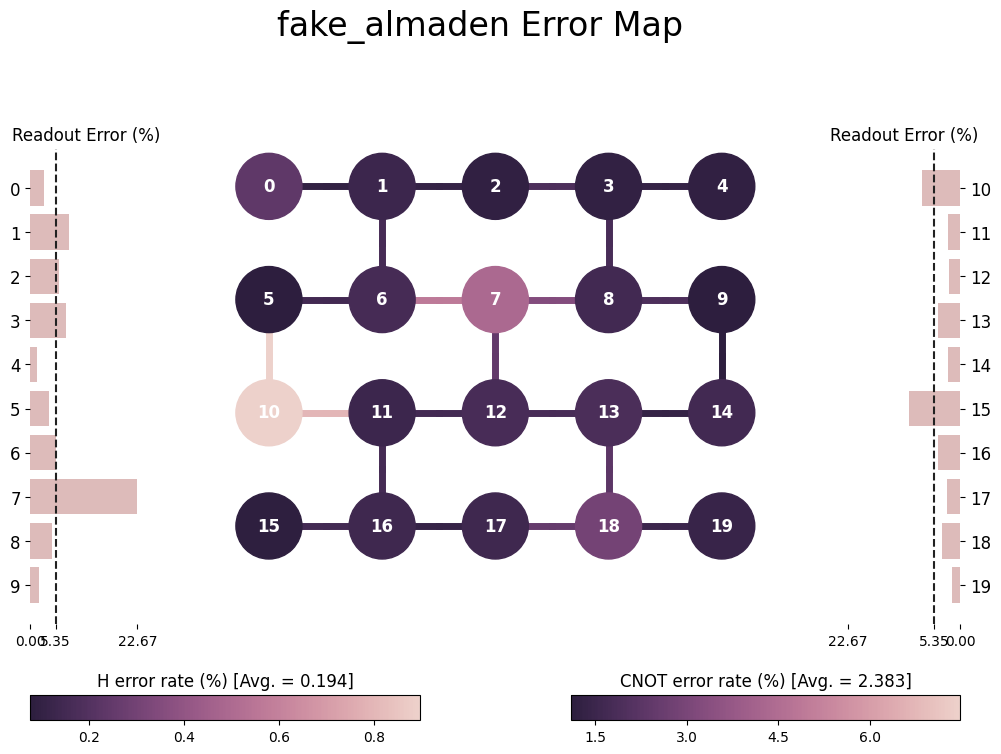

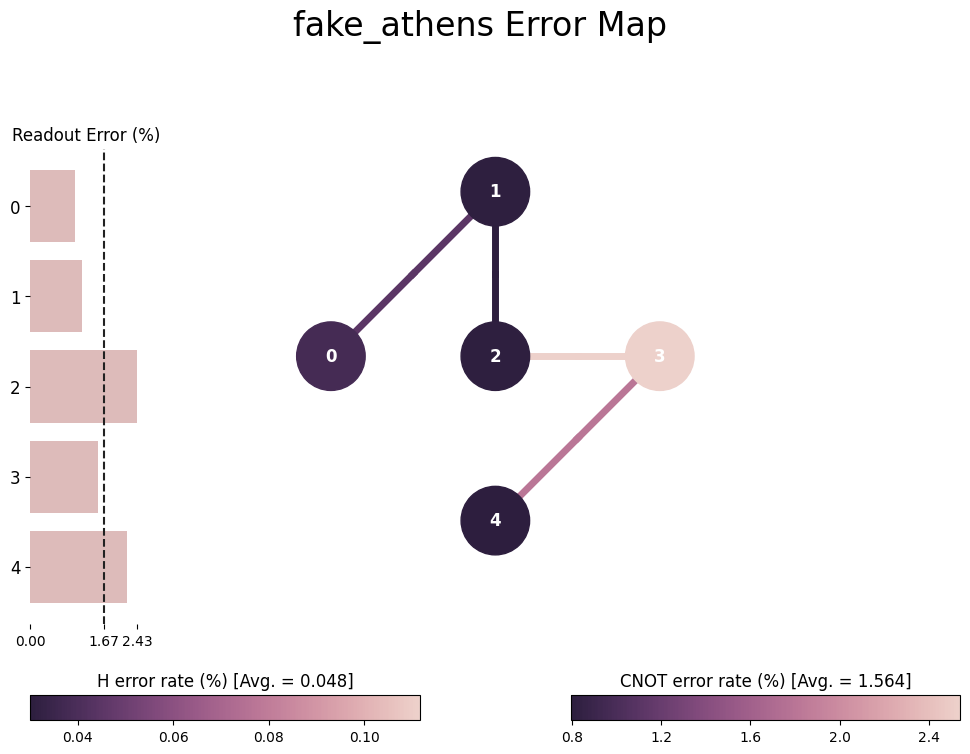

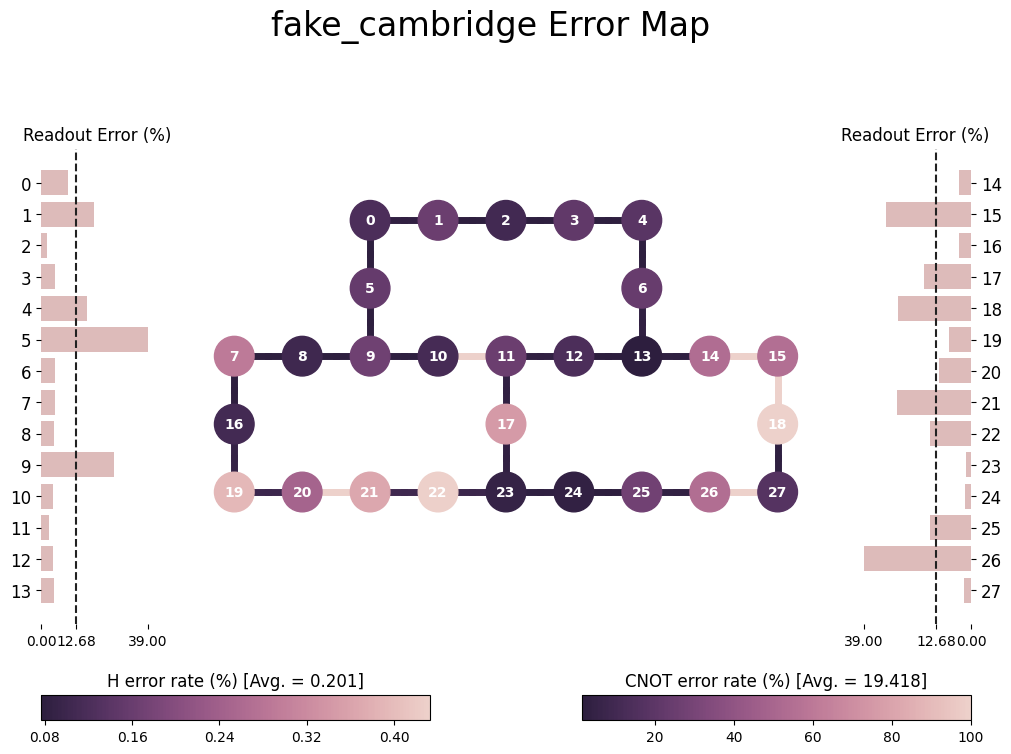

<Figure size 640x480 with 0 Axes>

In [12]:
make_plots(routing_backends, routing, "Backend", Num_qubits, "Number of Qubits", "Number of CNOTs")

#### Report
Summarize your findings from the part above. Analyze the differences between the architectures and how that affects the number of swaps necessary. Furthermore, discuss how you the circuit above maybe be rewritten to improve performance and reduce swaps.

#### Question 2

For this question you will explore the advantages of noise adaptive routing

Analyze how the mappings differ and in your report explain why there is a difference. Furthermore below select one of the circuits you constructed above: grovers, GHZ, BV, analyze how its routed on the three architectures FakeAlmadenV2,FakeAthensV2, FakeCambridgeV2. Analyze how the routing changes with different optimization levels. Refer to the Qiskit documentation for more info if needed. Only consider the case of 5 qubits.

In [13]:
def get_routing(backend):
    backend_obj = backend()
    for optimization_level in [0, 1, 2, 3]:
        quantum_circuit = make_bv(4, '1111')
        transpiled_circuit = transpile(quantum_circuit, backend_obj, optimization_level=optimization_level)
        fig = plot_circuit_layout(transpiled_circuit, backend_obj)
        display(fig)
        fig.savefig(f"Lab1/routing_{backend.__name__}_{optimization_level}.png")

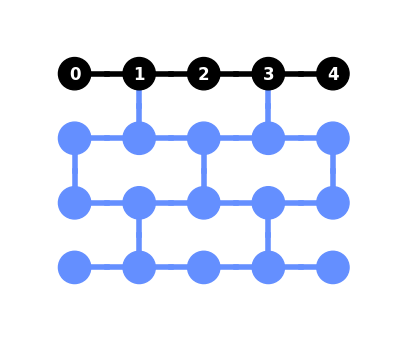

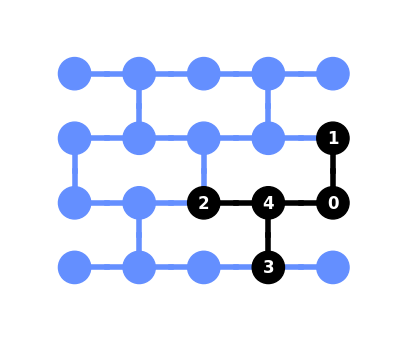

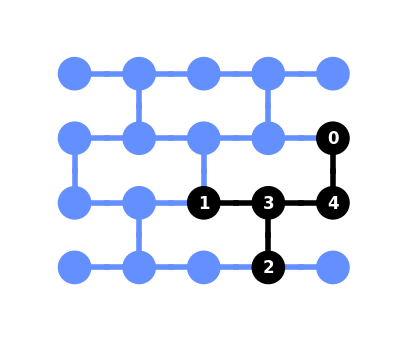

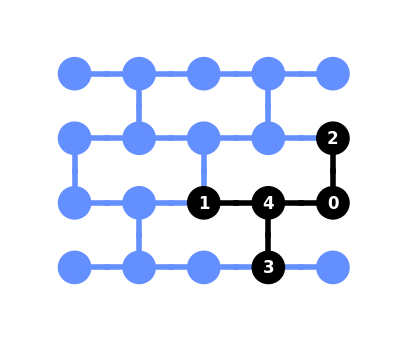

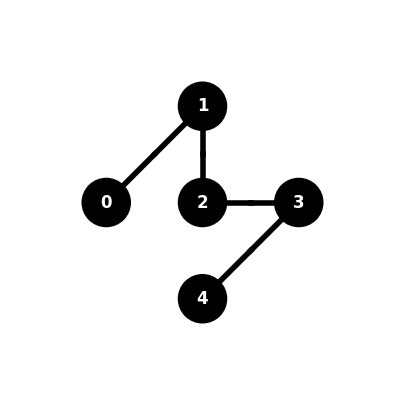

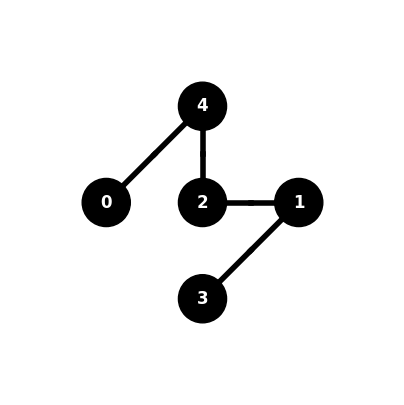

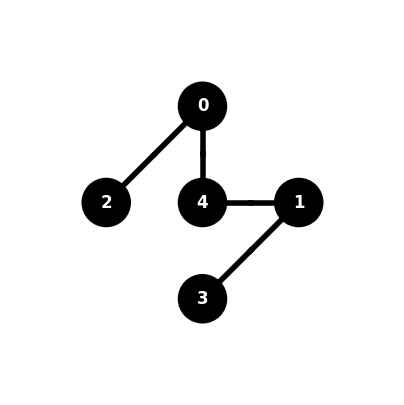

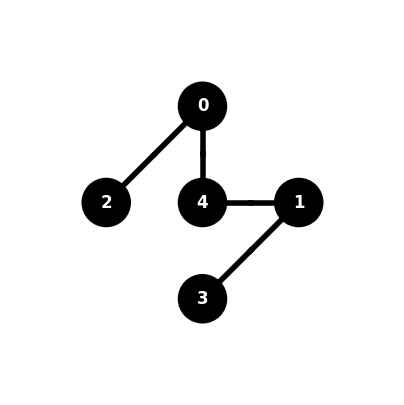

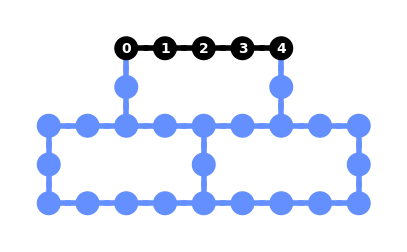

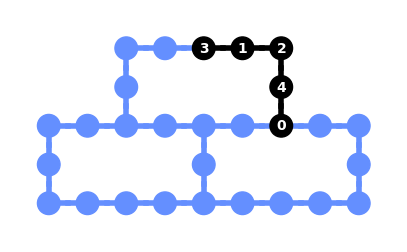

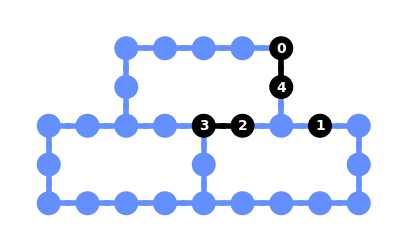

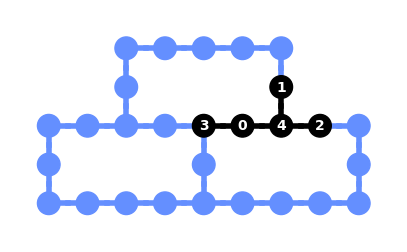

In [14]:
for backend in routing_backends:
    get_routing(backend)

#### Report

In your report summarize your findings and explain how in your experiments noise adaptive routing impacted the mapping of your qubit.

In [15]:
ghz_circuit = make_ghz(5)
ghz_circuit.draw(output='mpl').savefig("Lab1/ghz.png")

bv_circuit = make_bv(4, '1011')
bv_circuit.draw(output='mpl').savefig("Lab1/bv.png")

grover_circuit = make_grover(5, solution)
grover_circuit.draw(output='mpl').savefig("Lab1/grover.png")